# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.1MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

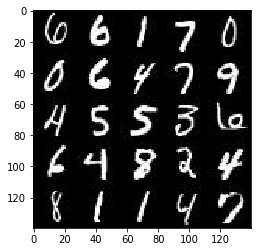

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

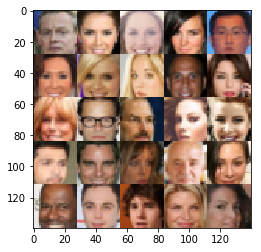

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name = 'lr')
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #input layer is 28x28x3
        # conv layer 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64 now
        
        # conv layer 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128 now
        
        # conv layer 3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4x4x256
        
#         # conv layer 4
#         x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same',
#                               kernel_initializer=tf.contrib.layers.xavier_initializer())
#         bn4 = tf.layers.batch_normalization(x4, training=True)
#         relu4 = tf.maximum(alpha * bn4, bn4)
#         #4x4x512
        
#         # conv layer 5
#         x5 = tf.layers.conv2d(relu4, 1024, 5, strides=1, padding='same',
#                               kernel_initializer=tf.contrib.layers.xavier_initializer())
#         bn5 = tf.layers.batch_normalization(x5, training=True)
#         relu5 = tf.maximum(alpha * bn5, bn5)
#         #4x4x1024
        
        # add regularization to improve losses
        drop = tf.nn.dropout(relu3, keep_prob=0.5)
        
        # flatten
        flat = tf.reshape(drop, (-1,4*4*256))
        
        # dense layer
        logits = tf.layers.dense(flat, 1,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        # reuse=not(is_train) because we want to reuse our parameters when generating images and not when training
        
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        # Conv layer 1
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Conv layer 2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Conv layer 3
        x4 = tf.layers.conv2d_transpose(x3, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x512 now
        
#         # Conv layer 4
#         x5 = tf.layers.conv2d_transpose(x4, 1024, 5, strides=1, padding='same',
#                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)
#         # 14x14x1024 now
        
#         # Conv layer 5
#         x6 = tf.layers.conv2d_transpose(x5, 2048, 5, strides=1, padding='same',
#                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x6 = tf.layers.batch_normalization(x6, training=is_train)
#         x6 = tf.maximum(alpha * x6, x6)
#         # 14x14x2048 now
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smoothing))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every = 100
    
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Re-scale the values from [-0.5, 0.5] to [-1, 1]
                batch_images = 2 * batch_images
                
                # Generate random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                steps = steps + 1
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 3.7388
Epoch 1/2... Discriminator Loss: 2.8828... Generator Loss: 3.3870
Epoch 1/2... Discriminator Loss: 2.0877... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 2.3479... Generator Loss: 0.3503
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 2.2624... Generator Loss: 0.3492
Epoch 1/2... Discriminator Loss: 1.8080... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.8242... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 1.8237... Generator Loss: 0.4161
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.4860


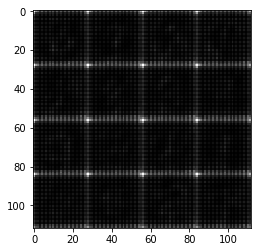

Epoch 1/2... Discriminator Loss: 1.7234... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.7523
Epoch 1/2... Discriminator Loss: 1.8043... Generator Loss: 1.5295
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 1.2260
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.7208... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.6254... Generator Loss: 0.6145


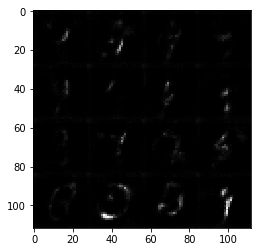

Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 1.1976
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 1.2346
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.5585
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.9472


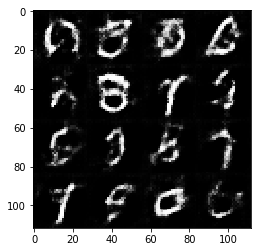

Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 1.2512
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 1.2759
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.6294... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 1.0751


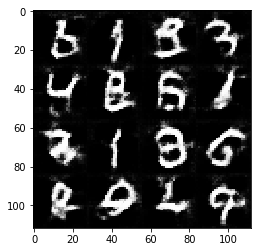

Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.8357
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.0331


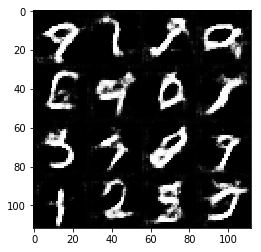

Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 1.1932
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 1.0433


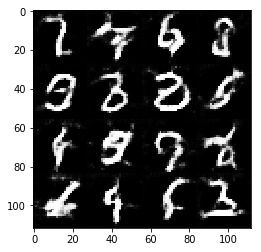

Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 1.4450
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 1.2576
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.6786


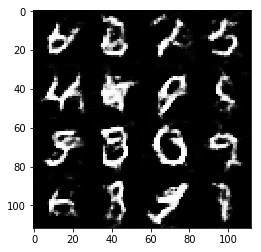

Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.4732
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.9609
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.6004... Generator Loss: 0.4867


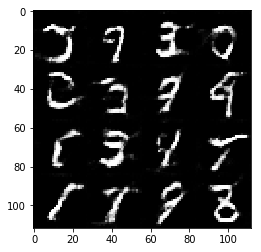

Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.1839
Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.7078
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.6580


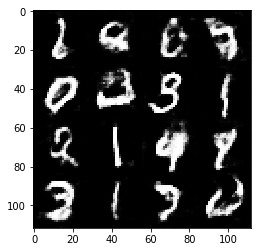

Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 1.2318
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 1.2110


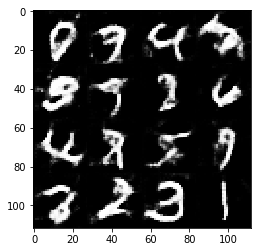

Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 1.4981... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 1.1590
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 1.4425
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.4702... Generator Loss: 1.1720


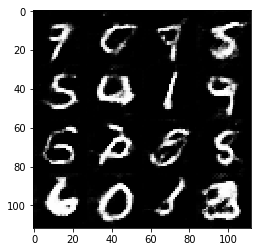

Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.5967
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 1.0441
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 1.4483... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.7581


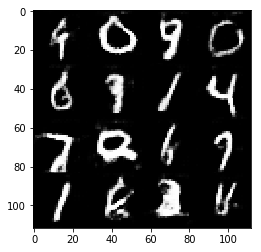

Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.5056
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.9432
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.9433


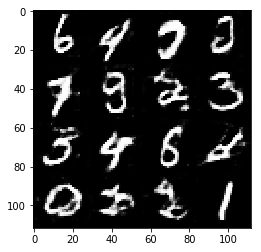

Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.8639
Epoch 2/2... Discriminator Loss: 1.4613... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.5245... Generator Loss: 1.2919


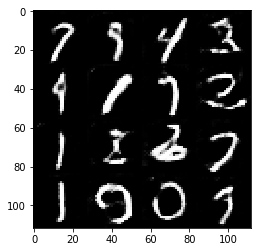

Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 1.3742
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.9143
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 2.0487... Generator Loss: 2.3510
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 1.0919
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6352


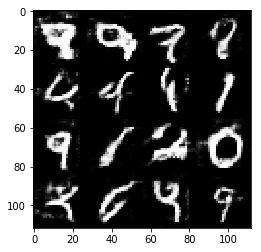

Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.8610
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 1.4855
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.7156


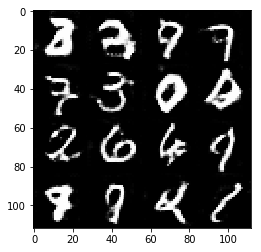

Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.9563
Epoch 2/2... Discriminator Loss: 1.6845... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.6955... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 1.0197


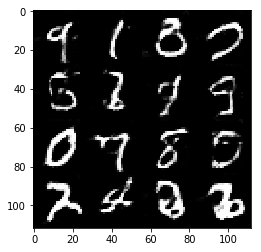

Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 1.6307
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.6981


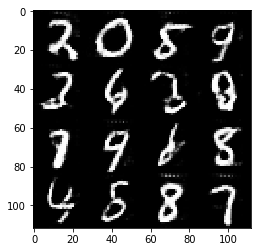

Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 1.2552
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.9293... Generator Loss: 0.2977
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.7254


In [12]:
batch_size = 64
z_dim = 100
learning_rate =  0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 2.6074... Generator Loss: 2.9896
Epoch 1/1... Discriminator Loss: 2.2909... Generator Loss: 3.9117
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 3.5783
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 3.2473
Epoch 1/1... Discriminator Loss: 2.2549... Generator Loss: 0.2787


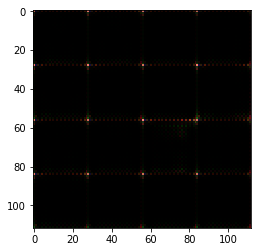

Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.8900
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 2.1123
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 2.5164
Epoch 1/1... Discriminator Loss: 2.3147... Generator Loss: 0.2338
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.9793
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 3.0397


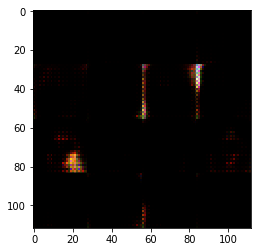

Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 4.1445
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.7835
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5579


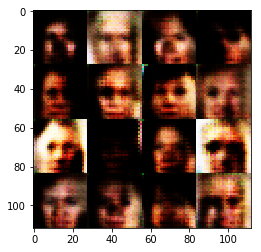

Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 4.0891
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.7960
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.7606... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.6249
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.4618
Epoch 1/1... Discriminator Loss: 2.4501... Generator Loss: 2.0076
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.6213


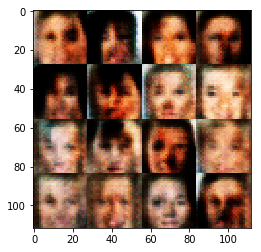

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 2.0138... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.6675


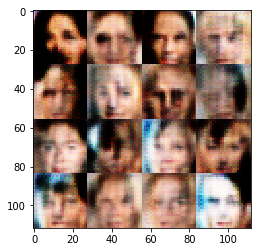

Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.9933... Generator Loss: 3.0036
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 3.0142
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.9386


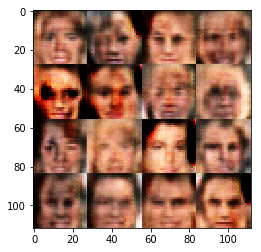

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.7475... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.7827... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4786


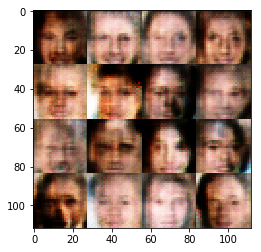

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 3.3517
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.9655


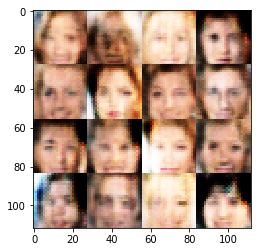

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 2.0417
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 2.0048
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 2.4501
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.7982
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.0909


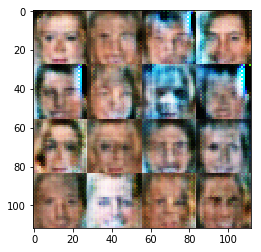

Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.4347
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 2.6918... Generator Loss: 3.1658
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.6670


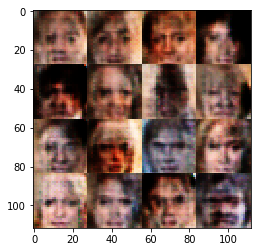

Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.7151
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.8288
Epoch 1/1... Discriminator Loss: 1.9232... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6929


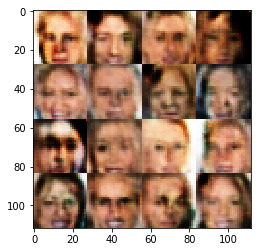

Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.1170
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 2.0351... Generator Loss: 2.2922
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 1.4578


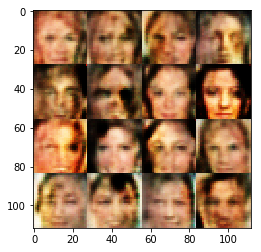

Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 2.3869
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.2586
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 3.0733
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 3.1121
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 2.5264
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.0871


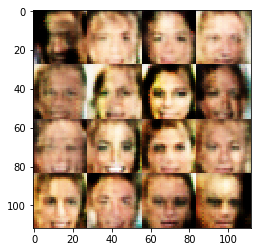

Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 1.8197
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 2.6235
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.3531
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.5105
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 2.9968
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.7528
Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.8859


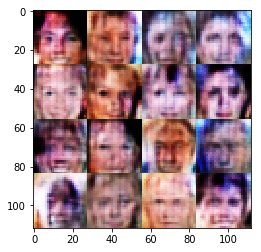

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.1261
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 2.1848... Generator Loss: 2.3021
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 1.8545


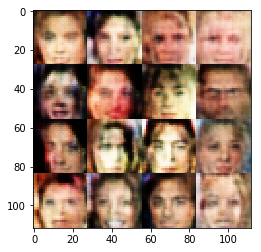

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 2.2674
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.6730


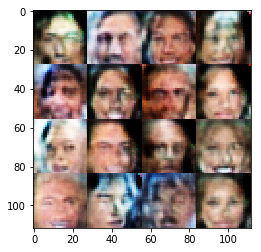

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.0989
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.6454
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 4.1995
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.4264


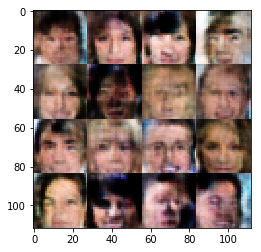

Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.2106


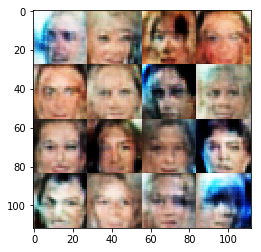

Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6851


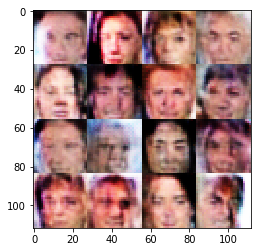

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.8393
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.8311... Generator Loss: 2.3063
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 2.6571
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.2393


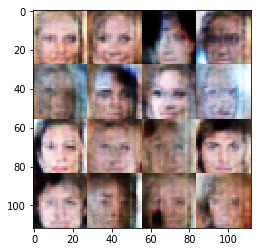

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 3.7829
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 2.2955
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.2032
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 2.2503
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.4319
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8844


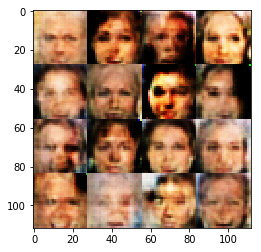

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 2.4075
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.5739


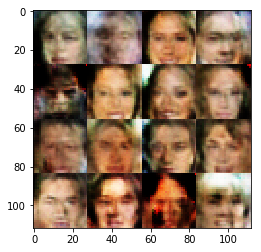

Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.7356
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2999
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.3921
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.4512


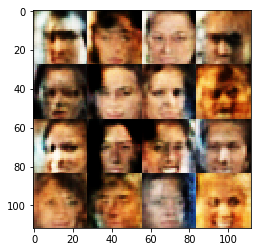

Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.8408
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.8275
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.9399


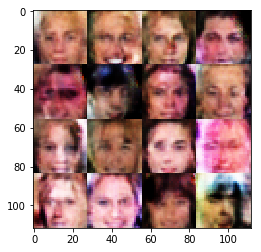

Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 2.5510
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.3902
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 3.1938
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.5414
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 2.9937


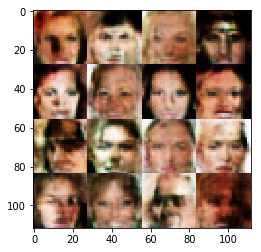

Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 3.1746
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 2.2569
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 2.1251


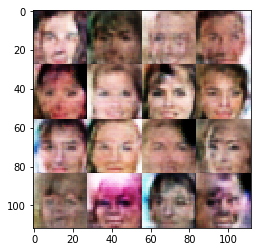

Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.2883


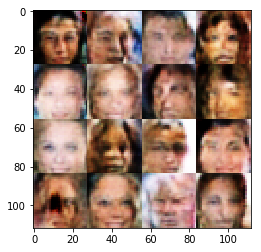

Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.6699... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 1.8839


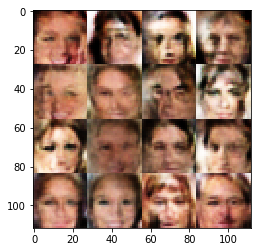

Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.4079
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 2.1200
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 3.1220


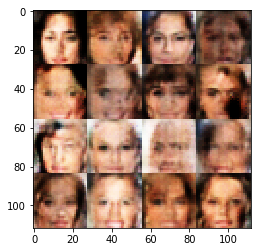

Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 3.6242
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 2.5363
Epoch 1/1... Discriminator Loss: 2.6672... Generator Loss: 2.9852
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 2.0666
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 3.2435
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 2.5517
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7554


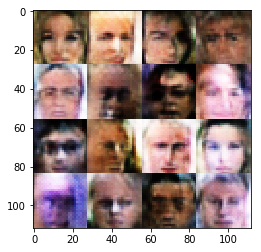

Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.7034
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 2.7923
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.6223
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 3.6449
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.7175
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.9271


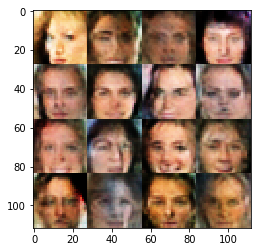

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 2.4505
Epoch 1/1... Discriminator Loss: 1.7755... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.9605


In [14]:
batch_size = 64
z_dim = 200
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.